#### Установка библиотек

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install default-jre

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
!java -version

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [4]:
!pip install h2o

#### Задание  
Построить обобщенную линейную модель (GLM) для прогнозирования наступления страховых случаев на рассмотренных в ноутбуке данных. Придумать и использовать дополнительные факторы при построении модели (например, пересечения признаков и т.д.). Оценить результаты построенной модели при помощи различных метрик (можно использовать и другие метрики помимо представленных в ноутбуке), выявить проблемы. Попробовать улучшить результат и предложить способы решения обнаруженных проблем.

#### Подключение библиотек

In [0]:
import numpy as np
import pandas as pd

In [0]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     
import itertools

In [7]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 10 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_unknownUser_uyo0rk
H2O cluster total nodes:,1
H2O cluster free memory:,2.495 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
def balance_df_by_target(df, target_name, balancing_type='oversampling', koeff_sampling=1):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.idxmax()
    minor_class_name = target_counts.idxmin()
    
    if balancing_type == 'oversampling':
        
        disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]*koeff_sampling) - 1

        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

        return df.sample(frac=1) 
    
    if balancing_type == 'undersampling':
        
        major_class_sample = df[df[target_name] == major_class_name].sample(target_counts[minor_class_name])
        minor_class_sample = df[df[target_name] == minor_class_name]
        
        df = pd.concat([major_class_sample, minor_class_sample], ignore_index=True)
        
        return df.sample(frac=1) 

#### Подоготовк данных

In [10]:
# Загрузим набор данных

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False, parse_dates=[2,3])
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int64
RecordBeg            115155 non-null datetime64[ns]
RecordEnd            59455 non-null datetime64[ns]
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int64
HasKmLimit           115155 non-null int64
BonusMalus           115155 non-null int64
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int64
ClaimNbResp          115155 non-null float64
ClaimNbNonResp       115155 non-null float64
ClaimNbParking       115155 non-null float64
ClaimNbFireTheft     115155 non-null float64
ClaimNbWindscreen    115155 non-null float64
OutUseNb             115155 non-null float64
RiskArea             115155 non-nul

In [11]:
df.nunique().sort_values()

HasKmLimit              2
Gender                  2
MariStat                2
ClaimInd                2
VehUsage                4
ClaimNbFireTheft        5
ClaimNbParking          6
ClaimNbResp             6
OutUseNb                6
ClaimNbWindscreen       8
ClaimNbNonResp          8
RiskArea               13
SocioCateg             46
DrivAge                80
BonusMalus            104
RecordEnd             365
RecordBeg             366
Exposure              761
LicAge                844
ClaimAmount          9588
dtype: int64

In [0]:

CAT_FEATURES = ['Gender', 'HasKmLimit','MariStat', 'VehUsage', 'OutUseNb', 'RiskArea', 'SocioCateg'  ]
NUM_FEATURES = ['LicAge',  'BonusMalus', 'Exposure', 'DrivAge']
FEATS = CAT_FEATURES + NUM_FEATURES + ['RecordBeg','RecordEnd']
TARGET = 'ClaimInd'
DELETE_FEATURES = ['ClaimNbFireTheft', 'ClaimNbParking', 'ClaimNbResp', 'ClaimNbWindscreen', 'ClaimNbNonResp', 'ClaimAmount']


In [0]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
df = df.drop(columns=DELETE_FEATURES, axis=1)
for column_name in CAT_FEATURES:
    #df[column_name] = df[column_name].astype('category')
    df[column_name ] = labelEncoder.fit_transform(df[column_name]) 
#df = pd.get_dummies(df, columns=['SocioCateg'])

In [0]:
from datetime import timedelta
df['RecordEnd'].fillna(df['RecordBeg']+timedelta(367), inplace=True)
df['Diff'] = df['RecordEnd']-df['RecordBeg']
df['Diff'] = df['Diff'].astype('int')

In [0]:
l_columns = NUM_FEATURES.copy()
for colname in l_columns:
    df[colname + ' (^2)'] = df[colname] ** 2
    df[colname + ' (^3)'] = df[colname] ** 3
    df[colname + ' (sqrt)'] = np.sqrt(df[colname])
    df[colname + ' (log)'] = np.log(df[colname])
      
    NUM_FEATURES.extend([colname + ' (^2)', colname + ' (^3)', colname + ' (sqrt)', colname + ' (log)'])

for colname1, colname2 in itertools.combinations(l_columns, 2):
    df[colname1 + ' mult. ' + colname2] = df[colname1] * df[colname2]
    df[colname1 + ' div. ' + colname2] = df[colname1] / df[colname2]
    df[colname2 + ' div. ' + colname1] = df[colname2] / df[colname1]
  
    NUM_FEATURES.extend([colname1 + ' mult. ' + colname2, 
                              colname1 + ' div. ' + colname2, 
                              colname2 + ' div. ' + colname1])

In [16]:
df.loc[df['ClaimInd']==1].head()

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimInd,OutUseNb,RiskArea,Diff,LicAge (^2),LicAge (^3),LicAge (sqrt),LicAge (log),BonusMalus (^2),BonusMalus (^3),BonusMalus (sqrt),BonusMalus (log),Exposure (^2),Exposure (^3),Exposure (sqrt),Exposure (log),DrivAge (^2),DrivAge (^3),DrivAge (sqrt),DrivAge (log),LicAge mult. BonusMalus,LicAge div. BonusMalus,BonusMalus div. LicAge,LicAge mult. Exposure,LicAge div. Exposure,Exposure div. LicAge,LicAge mult. DrivAge,LicAge div. DrivAge,DrivAge div. LicAge,BonusMalus mult. Exposure,BonusMalus div. Exposure,Exposure div. BonusMalus,BonusMalus mult. DrivAge,BonusMalus div. DrivAge,DrivAge div. BonusMalus,Exposure mult. DrivAge,Exposure div. DrivAge,DrivAge div. Exposure
33,0.617,602,2004-05-19,2005-05-21,1,1,37,0,68,0,50,1,0,3,31708800000000000,362404,218167208,24.535688,6.400257,2500,125000,7.071068,3.912023,0.380689,0.234885,0.785493,-0.482886,4624,314432,8.246211,4.219508,30100,12.040000,0.083056,371.434,975.688817,0.001025,40936,8.852941,0.112957,30.850,81.037277,0.012340,3400,0.735294,1.360000,41.956,0.009074,110.210697
34,0.761,357,2004-01-01,2004-10-05,0,0,32,1,47,0,50,1,0,5,24019200000000000,127449,45499293,18.894444,5.877736,2500,125000,7.071068,3.912023,0.579121,0.440711,0.872353,-0.273122,2209,103823,6.855655,3.850148,17850,7.140000,0.140056,271.677,469.119580,0.002132,16779,7.595745,0.131653,38.050,65.703022,0.015220,2350,1.063830,0.940000,35.767,0.016191,61.760841
53,0.023,271,2004-10-23,2004-11-01,1,1,29,1,49,0,50,1,2,7,777600000000000,73441,19902511,16.462078,5.602119,2500,125000,7.071068,3.912023,0.000529,0.000012,0.151658,-3.772261,2401,117649,7.000000,3.891820,13550,5.420000,0.184502,6.233,11782.608696,0.000085,13279,5.530612,0.180812,1.150,2173.913043,0.000460,2450,1.020408,0.980000,1.127,0.000469,2130.434783
65,0.833,539,2004-01-01,2004-11-01,1,1,37,0,75,0,50,1,0,8,26352000000000000,290521,156590819,23.216374,6.289716,2500,125000,7.071068,3.912023,0.693889,0.578010,0.912688,-0.182722,5625,421875,8.660254,4.317488,26950,10.780000,0.092764,448.987,647.058824,0.001545,40425,7.186667,0.139147,41.650,60.024010,0.016660,3750,0.666667,1.500000,62.475,0.011107,90.036014
66,0.957,302,2004-01-01,2004-12-16,0,1,32,1,49,0,54,1,0,7,30240000000000000,91204,27543608,17.378147,5.710427,2916,157464,7.348469,3.988984,0.915849,0.876467,0.978264,-0.043952,2401,117649,7.000000,3.891820,16308,5.592593,0.178808,289.014,315.569488,0.003169,14798,6.163265,0.162252,51.678,56.426332,0.017722,2646,1.102041,0.907407,46.893,0.019531,51.201672


In [0]:
# Разбиение датасета на train/val/test

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df.drop(columns=[TARGET], axis=1), df[TARGET], stratify= df[TARGET], test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_train_ind, y_train_ind, stratify= y_train_ind, test_size=0.5, random_state=1)

In [18]:
df_for_balancing = pd.concat([x_train_ind, y_train_ind], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET, balancing_type='oversampling', koeff_sampling=0.5)
df_balanced[TARGET].value_counts()

0    73000
1    30432
Name: ClaimInd, dtype: int64

In [0]:
x_train_ind = df_balanced.drop(columns=TARGET)
y_train_ind = df_balanced[TARGET]

In [20]:
# Преобразование в H2O-Frame
h2o_train = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных
h2o_train[TARGET] = h2o_train[TARGET].asfactor()
h2o_valid[TARGET] = h2o_valid[TARGET].asfactor()
h2o_test[TARGET] = h2o_test[TARGET].asfactor()

#### Создание модели

In [22]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_binomial = H2OGeneralizedLinearEstimator(family = 'binomial',  nfolds=5, seed=1, standardize=True, fold_assignment='Modulo', prior=0.284)#,  lambda_search=True, nlambdas=5, 'Stratified'
glm_binomial.train(y=TARGET, x = h2o_train.names[1:-1], training_frame = h2o_train, validation_frame = h2o_valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [23]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_binomial.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 2.508E-4 )",47,31,4,py_1_sid_af25


In [24]:
# Метрики качества модели - по всем данным и на кросс-валидации
glm_binomial.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.5693986,0.018995231,0.5571132,0.54551166,0.5705308,0.5942183,0.57961905
1,auc,0.6930618,0.0047405646,0.6881675,0.6909091,0.6998957,0.6958684,0.6904686
2,aucpr,0.44723263,0.009352237,0.43653786,0.44943592,0.45496452,0.45684698,0.4383779
3,err,0.4306014,0.018995231,0.44288683,0.45448834,0.4294692,0.4057817,0.42038092
4,err_count,8907.6,393.14984,9162.0,9402.0,8884.0,8394.0,8696.0
5,f0point5,0.43349525,0.009781714,0.42260984,0.4284495,0.43680266,0.44841403,0.4312003
6,f1,0.52412117,0.0075105405,0.5150328,0.5262044,0.5300963,0.53179383,0.51747864
7,f2,0.66303974,0.014507898,0.6591962,0.6817529,0.6740651,0.6532643,0.6469201
8,lift_top_group,1.8982483,0.16045168,1.8146185,1.6577646,2.0518308,1.9870161,1.9800119
9,logloss,0.55484015,0.002858208,0.55475247,0.5580045,0.5510653,0.55720955,0.55316883


In [25]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)
pd.set_option('display.max_rows', None)
df_model = glm_binomial._model_json['output']['coefficients_table'].as_data_frame()
df_model.loc[df_model['standardized_coefficients']!=0].sort_values(['standardized_coefficients'], ascending=[False])

,names,coefficients,standardized_coefficients
24,Exposure (sqrt),2.401155e+00,0.573164
25,Exposure (log),4.290518e-01,0.440046
2,RecordBeg,1.558418e-11,0.153588
7,VehUsage,1.645796e-01,0.118311
30,LicAge mult. BonusMalus,1.180369e-05,0.097902
32,BonusMalus div. LicAge,1.783829e-01,0.091301
42,BonusMalus mult. DrivAge,9.486053e-05,0.076079
46,Exposure div. DrivAge,9.329059e+00,0.072560
11,OutUseNb,9.619375e-02,0.068416
33,LicAge mult. Exposure,4.776458e-04,0.063158


In [26]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_binomial.coef_norm()
for x in range(len(glm_binomial.cross_validation_models())):
    pmodels[x] = glm_binomial.cross_validation_models()[x].coef_norm()
df_model_cross_validation = pd.DataFrame.from_dict(pmodels).round(5)
df_model_cross_validation.loc[df_model_cross_validation['overall']!=0]

,overall,0,1,2,3,4
Intercept,-1.07509,-1.07830,-1.07623,-1.07043,-1.07358,-1.07545
RecordBeg,0.15359,0.16132,0.14995,0.12737,0.15964,0.15136
Gender,0.00391,0.00527,0.00724,-0.00110,0.00693,0.00138
MariStat,0.04395,0.04604,0.04590,0.03738,0.04046,0.04766
SocioCateg,0.02786,0.02858,0.02596,0.03178,0.02487,0.02478
VehUsage,0.11831,0.11945,0.11042,0.11453,0.12603,0.11941
HasKmLimit,-0.10065,-0.09757,-0.10600,-0.09895,-0.09993,-0.10037
BonusMalus,-0.04643,0.00000,-0.00524,-0.00005,-0.00873,-0.05541
OutUseNb,0.06842,0.06577,0.06802,0.07399,0.06674,0.06670
RiskArea,0.00356,0.00000,0.00479,0.00867,0.00238,0.00169


In [27]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок
train_pred = glm_binomial.predict(h2o_train).as_data_frame()
valid_pred = glm_binomial.predict(h2o_valid).as_data_frame()
test_pred = glm_binomial.predict(h2o_test).as_data_frame()


glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


#### Оценка модели

In [28]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок
print(f"accuracy score for train = {accuracy_score(train_pred['predict'], y_train_ind)}")
print(f"accuracy score for valid = {accuracy_score(valid_pred['predict'], y_valid_ind)}")
print(f"accuracy score for test = {accuracy_score(test_pred['predict'], y_test_ind)}\n")

print(f"f1 score for train = {f1_score(train_pred['predict'], y_train_ind)}")
print(f"f1 score for valid = {f1_score(valid_pred['predict'], y_valid_ind)}")
print(f"f1 score for test = {f1_score(test_pred['predict'], y_test_ind)}\n")
cm = confusion_matrix(y_test_ind, test_pred['predict'])
cm

accuracy score for train = 0.6811431665248666
accuracy score for valid = 0.7420603414053196
accuracy score for test = 0.7404227868201667

f1 score for train = 0.46382701999674847
f1 score for valid = 0.25975505553973227
f1 score for test = 0.24949784791965565



array([[28103,  8397],
       [ 2065,  1739]])

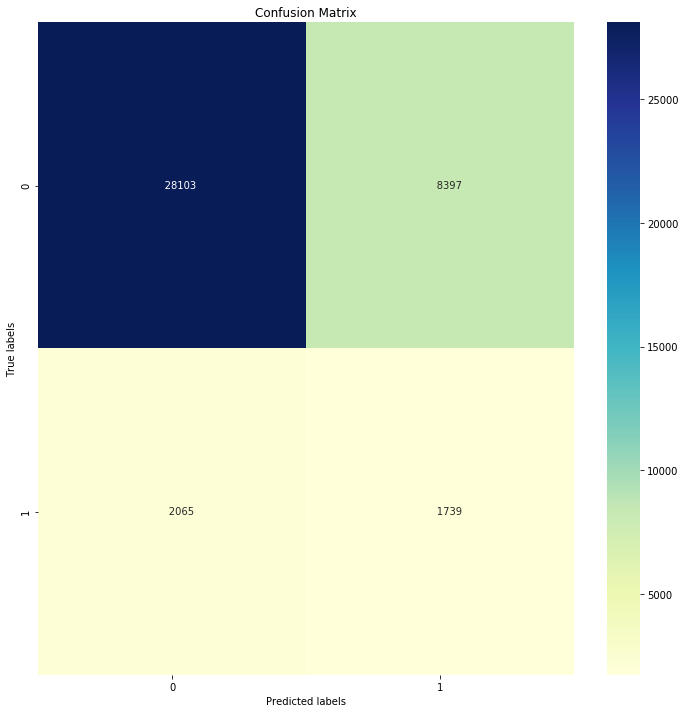

In [29]:
plt.figure(figsize=(12, 12))
ax= plt.subplot()

sns.heatmap(cm,  cmap="YlGnBu", annot=True, ax = ax, fmt='10d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


### Какие проблемы вы здесь видите? Как можно улучшить данный результат?

1. Сильный дисбаланс классов - нужно больше данных с информацией о страховках, по которым наступил страховой случай. Oversampling помогает улучшить оценки, но TN сопоставим с TP.
2. Часть сгенерированных признаков мультиколлинеарны - необходимо проанализировать модель на возможность отбросить часть из них. 